In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTENC
warnings.filterwarnings('ignore')

In [68]:
# Załadowanie danych
train_df = pd.read_csv('train_df.csv', index_col=0)
test_df = pd.read_csv('test_df.csv', index_col=0)

# Oznaczenie zbioru treningowego i testowego
train_df['__is_train'] = 1
test_df['__is_train'] = 0

# Połączenie zbiorów
combined = pd.concat([train_df, test_df], axis=0)

# Kodowanie One-Hot Encoding
combined = pd.get_dummies(combined, drop_first=True)
train_df = combined[combined['__is_train'] == 1].drop(columns='__is_train')
test_df = combined[combined['__is_train'] == 0].drop(columns='__is_train')

# Podział na cechy i etykiety
X_train = train_df.drop('stroke', axis=1)
y_train = train_df['stroke']

X_test = test_df.drop('stroke', axis=1)
y_test = test_df['stroke']

In [69]:
# Indeksy cech kategorycznych po One-Hot Encoding
index_of_categorical_features = [1, 2, 5, 6, 7, 8, 9, 10, 11]

# Zastosowanie SMOTENC
sm = SMOTENC(categorical_features=index_of_categorical_features, random_state=42, sampling_strategy='auto')
X_train_resampled, y_train_resampled = sm.fit_resample(X_train, y_train)

print("Rozmiar danych po SMOTENC:")
print("X_train_resampled shape:", X_train_resampled.shape)
print("y_train_resampled shape:", y_train_resampled.shape)


Rozmiar danych po SMOTENC:
X_train_resampled shape: (7784, 12)
y_train_resampled shape: (7784,)


In [70]:
# CELL 4: Inicjalizacja i trenowanie modelu Random Forest
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=5,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features='sqrt',
    class_weight='balanced',
    random_state=42
)

print("Training the Random Forest model...")
rf_model.fit(X_train_resampled, y_train_resampled)

Training the Random Forest model...


RandomForestClassifier(class_weight='balanced', max_depth=5, n_estimators=300,
                       random_state=42)

In [71]:
# Ocena modelu i wyświetlenie metryk
from sklearn.metrics import recall_score, roc_auc_score, precision_recall_fscore_support

print("\nRandom Forest Evaluation:")

# Przewidywanie prawdopodobieństwa
y_proba = rf_model.predict_proba(X_test)[:, 1]

# Zastosowanie progu do generowania prognoz binarnych
y_pred = (y_proba >= 0.5).astype(int)

# Obliczanie metryk
auc = roc_auc_score(y_test, y_proba)
recall = recall_score(y_test, y_pred)
precision, recall_macro, f1_score_macro, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')

# Wyniki
print(f"AUC: {auc:.4f}")
print(f"TPR (Recall): {recall:.4f}")
print(f"Macro avg Precision: {precision:.4f}")
print(f"Macro avg Recall: {recall_macro:.4f}")
print(f"Macro avg F1-score: {f1_score_macro:.4f}")


Random Forest Evaluation:
AUC: 0.8125
TPR (Recall): 0.6296
Macro avg Precision: 0.5536
Macro avg Recall: 0.7007
Macro avg F1-score: 0.5406


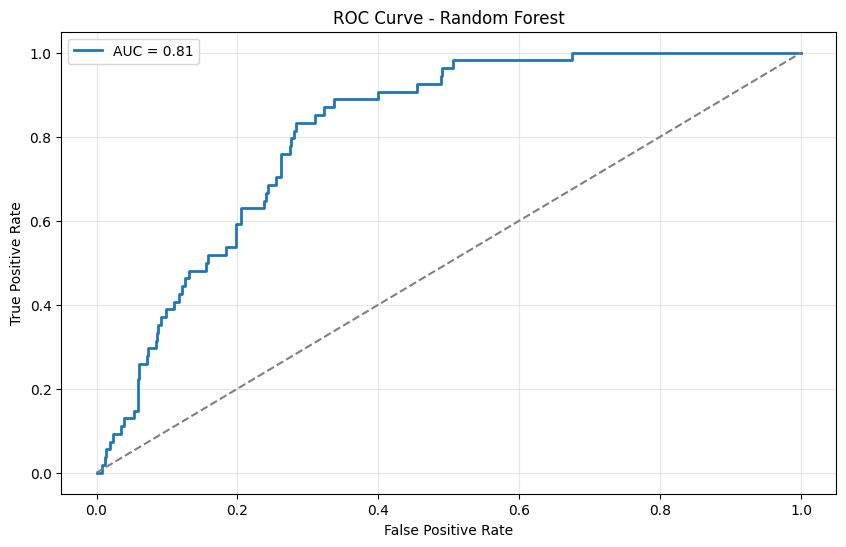

In [72]:
# Wizualizacja krzywej ROC
fpr, tpr, _ = roc_curve(y_test, y_proba)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label="AUC = {:.2f}".format(auc), linewidth=2)
plt.plot([0, 1], [0, 1], linestyle='--', color='grey')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Random Forest")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

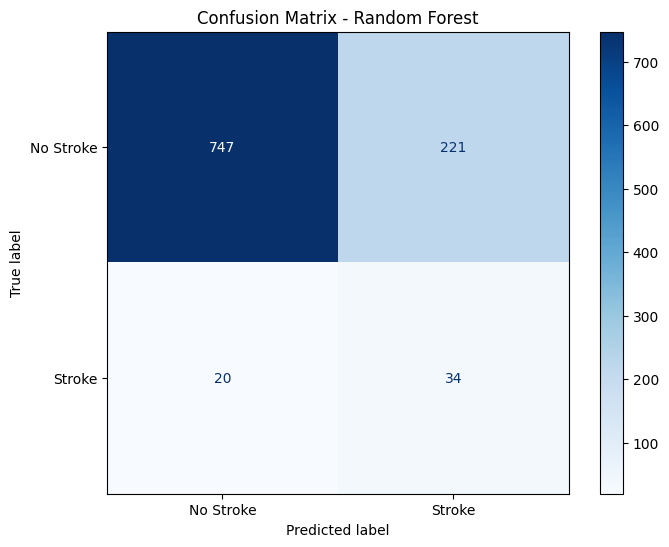

In [73]:
from sklearn.metrics import ConfusionMatrixDisplay

# Generowanie confusion matrix
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Stroke", "Stroke"])

# Wykres confusion matrix
fig, ax = plt.subplots(figsize=(8, 6))
cmd.plot(ax=ax, cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Random Forest")
plt.grid(False)
plt.show()

# Summary

## Random Forest Evaluation:
1. AUC: **0.8125**
2. TPR: **0.6296**
3. Macro avg Precision: **0.5536**
4. Macro avg Recall: **0.7007**
5. Macro avg F1-score: **0.5406**